In [1]:
import numpy as np
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import pmlb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Embedding, Reshape, RepeatVector, Multiply, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Importing necessary modules
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from model_data_definitions import *
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:
metadata_path = os.path.join(os.path.dirname(pmlb.__file__), 'all_summary_stats.tsv')
metadata = pd.read_csv(metadata_path, sep='\t')

filtered_datasets = metadata[
    (metadata['n_features'] < 7) &
    (metadata['n_binary_features'] == 0) &
    (metadata['n_categorical_features'] == 0) &
    (metadata['n_continuous_features'] == metadata['n_features'] ) &
    #(metadata['n_instances'] >= 500) &
    #(metadata['n_instances'] <= 1000) &
    (metadata['endpoint_type'] == 'continuous') &
    (metadata['task'] == 'regression')
]

In [3]:
filtered_datasets

,dataset,n_instances,n_features,n_binary_features,n_categorical_features,n_continuous_features,endpoint_type,n_classes,imbalance,task
0,1027_ESL,488,4,0,0,4,continuous,9.0,0.099363,regression
2,1029_LEV,1000,4,0,0,4,continuous,5.0,0.111245,regression
3,1030_ERA,1000,4,0,0,4,continuous,9.0,0.031251,regression
5,1096_FacultySalaries,50,4,0,0,4,continuous,39.0,0.004063,regression
13,192_vineyard,52,2,0,0,2,continuous,19.0,0.040475,regression
23,228_elusage,55,2,0,0,2,continuous,52.0,0.000953,regression
25,230_machine_cpu,209,6,0,0,6,continuous,116.0,0.004906,regression
29,485_analcatdata_vehicle,48,4,0,0,4,continuous,47.0,0.000434,regression
32,519_vinnie,380,2,0,0,2,continuous,16.0,0.030146,regression
34,523_analcatdata_neavote,100,2,0,0,2,continuous,8.0,0.136914,regression


In [9]:
import glob
import os

def create_model_name_list():
    """
    Function to create model name list
    """
    common_args = {
        'input_dim': 1, 
        'output_dim': 1, 
        'seed': 1
    }

    models = [
        (create_linear_model(**common_args), "Linear Model"),
        (create_wide_relu_ann(hidden_units=1000, **common_args), "Wide ReLU ANN"),
        (create_deep_relu_ann(hidden_units=16, hidden_layers=8, **common_args), "Deep ReLU ANN"),
        (LookupTableModel(partition_num=1, default_val=-1., **common_args), "One Parameter")
    ]

    for partition_num in [1,2,4,8,10]:
        models.append((SplineANN(partition_num=partition_num, **common_args), 
                       f"Spline ANN (z={partition_num})"))
        models.append((LookupTableModel(partition_num=partition_num, default_val=-1., **common_args),
                       f"Lookup Table (z={partition_num})"))
        models.append((ABELSpline(partition_num=partition_num, num_exps=6, **common_args), 
                       f"ABEL-Spline (z={partition_num})"))

    model_names = [model[1] for model in models]

    return model_names

def create_dataset_name_list():
    """
    Function to create dataset name list
    """
  
   # Same as the above provided code snippet but returns a list of dataset names instead.
    metadata_path = os.path.join(os.path.dirname(pmlb.__file__), 'all_summary_stats.tsv')
    metadata = pd.read_csv(metadata_path, sep='\t')

    filtered_datasets = metadata[
       (metadata['n_features'] < 7) &
       (metadata['n_binary_features'] == 0) &
       (metadata['n_categorical_features'] == 0) &
       (metadata['n_continuous_features'] == metadata['n_features'] ) &
       #(metadata['n_instances'] >= 500) &
       #(metadata['n_instances'] <= 1000) &
       (metadata['endpoint_type'] == 'continuous') &
       (metadata['task'] == 'regression')
   ]

    return filtered_datasets["dataset"].tolist()

def get_results_for_dataset(dataset_name, epoch_number=100, num_folds=10):
    """
    Function to grab all the relevant information from the aggregate_results folder
    """

    model_names = create_model_name_list()
    
    results = {}

    for model_name in model_names:
        model_results = []
        
        for fold in range(1, num_folds+1):
            file_path = f'aggregate_results/{dataset_name}-{model_name}-epochs-{epoch_number}-fold-{fold}-of-{num_folds}.npy'
            
            if os.path.exists(file_path):
                result = np.load(file_path, allow_pickle=True).item()
                model_results.append(result)
        
        if model_results:
            results[model_name] = model_results
        
    return results

# Create a list of dataset names
dataset_names = create_dataset_name_list()


In [10]:
dataset_names = ['1027_ESL',
 '1029_LEV',
 '1030_ERA',
 '1096_FacultySalaries',
 '192_vineyard',
 '228_elusage',
 '230_machine_cpu',
 '485_analcatdata_vehicle',
 '519_vinnie',
 '523_analcatdata_neavote',
 '529_pollen',
 '556_analcatdata_apnea2',
 '557_analcatdata_apnea1',
 '579_fri_c0_250_5',
 '594_fri_c2_100_5',
 '596_fri_c2_250_5',
 '597_fri_c2_500_5',
 '599_fri_c2_1000_5',
 '601_fri_c1_250_5',
 '609_fri_c0_1000_5',
 '611_fri_c3_100_5',
 '612_fri_c1_1000_5',
 '613_fri_c3_250_5',
 '617_fri_c3_500_5',
 '624_fri_c0_100_5',
 '628_fri_c3_1000_5',
 '631_fri_c1_500_5']

In [11]:

# Use a for loop to iterate over the dataset names
for dataset in dataset_names:
    results = get_results_for_dataset(dataset)

In [14]:
results['ABEL-Spline (z=1)']

[{'model': 'ABEL-Spline (z=1)',
  'fold': 1,
  'train_history': [0.820684015750885,
   0.7889094948768616,
   0.7627508640289307,
   0.7396988868713379,
   0.7178913950920105,
   0.6966887712478638,
   0.677639901638031,
   0.6583024859428406,
   0.6402352452278137,
   0.6262891888618469,
   0.6109470725059509,
   0.5986998677253723,
   0.5869678258895874,
   0.5758769512176514,
   0.5661223530769348,
   0.5553369522094727,
   0.544754147529602,
   0.5362261533737183,
   0.5243980288505554,
   0.5118928551673889,
   0.5029682517051697,
   0.49161359667778015,
   0.47978511452674866,
   0.4701264500617981,
   0.4614585340023041,
   0.452105313539505,
   0.4446733593940735,
   0.43900266289711,
   0.4294106960296631,
   0.4240986406803131,
   0.41825610399246216,
   0.4120859205722809,
   0.4047117829322815,
   0.39803194999694824,
   0.3923960328102112,
   0.38687482476234436,
   0.38159555196762085,
   0.3790506422519684,
   0.3724411725997925,
   0.36874884366989136,
   0.366497725248

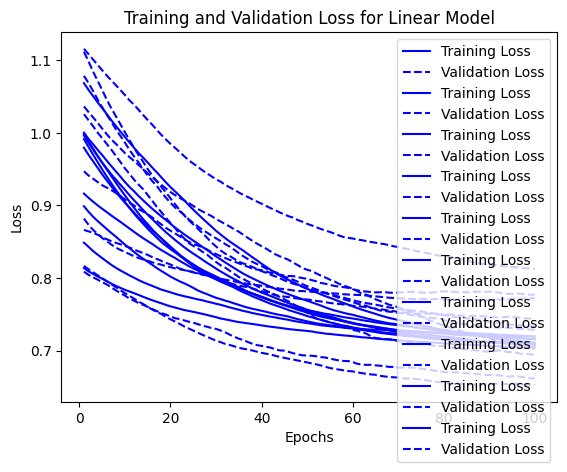

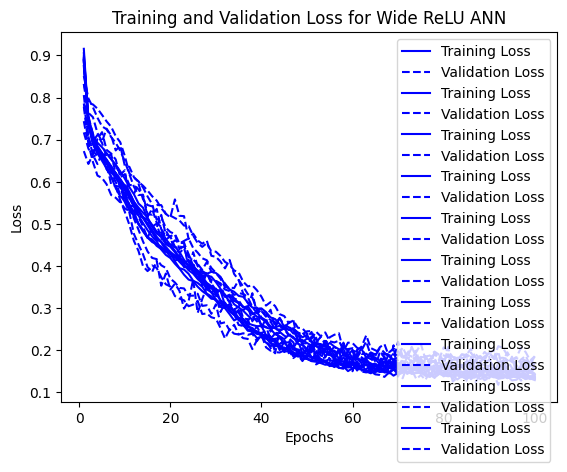

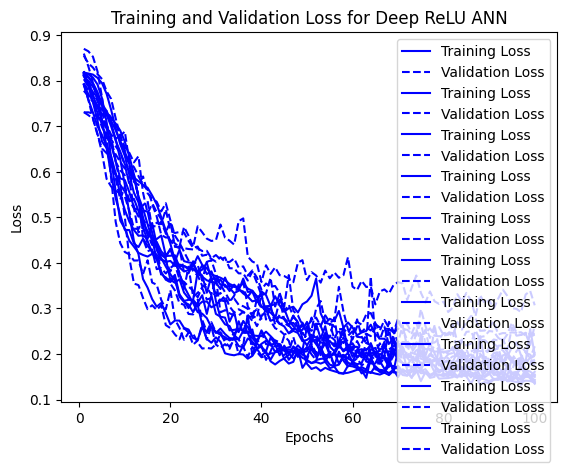

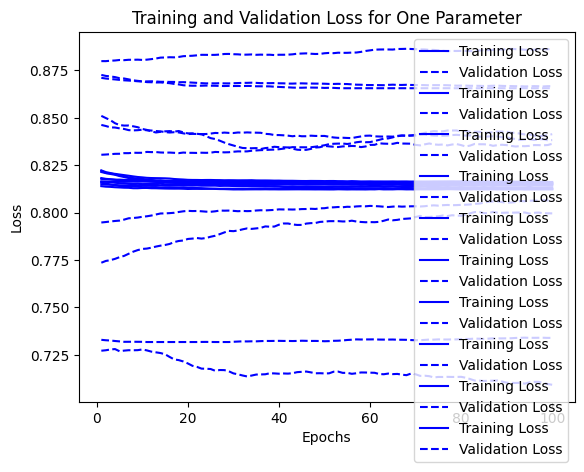

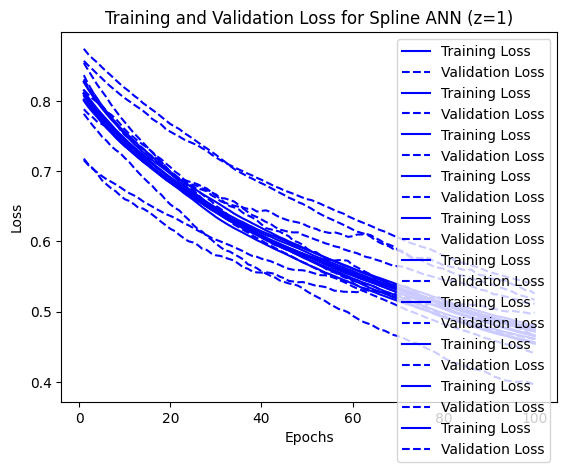

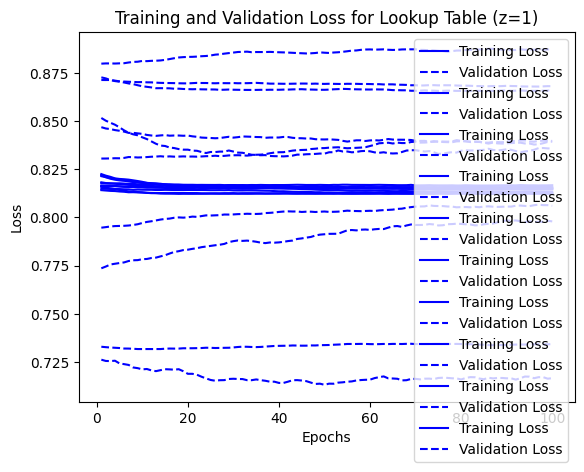

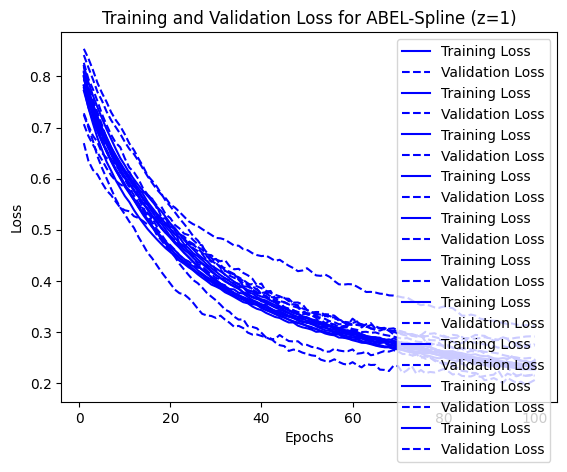

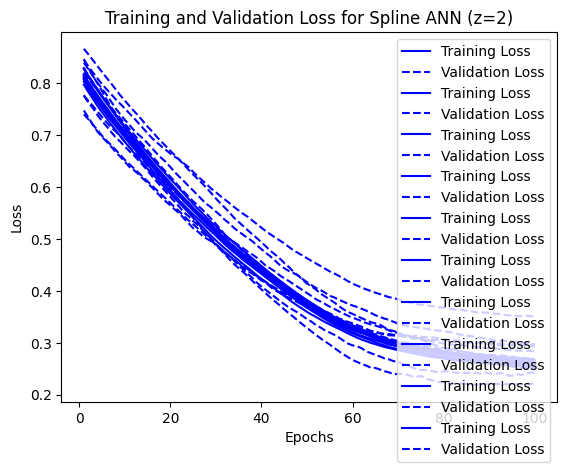

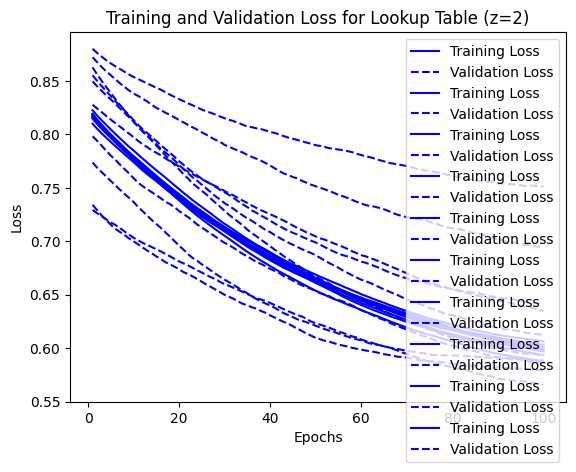

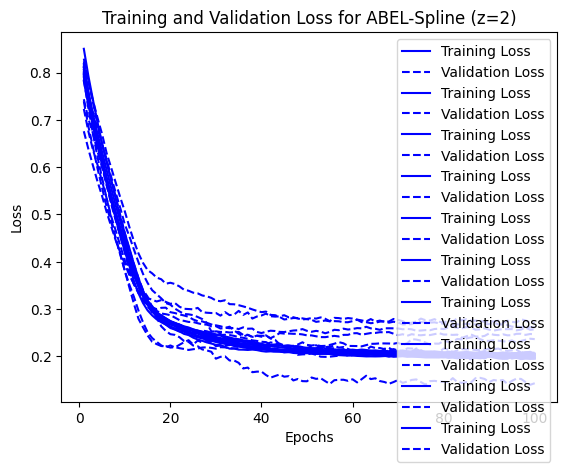

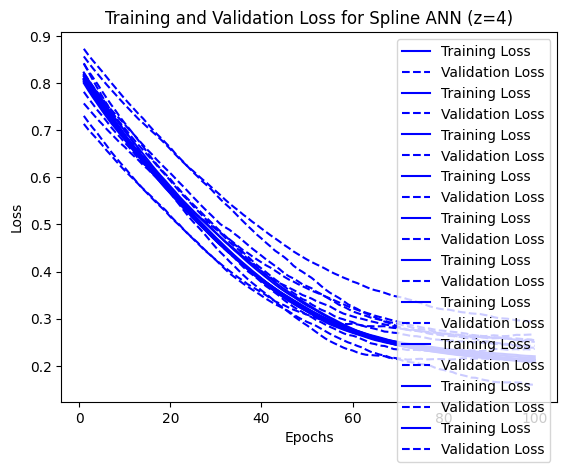

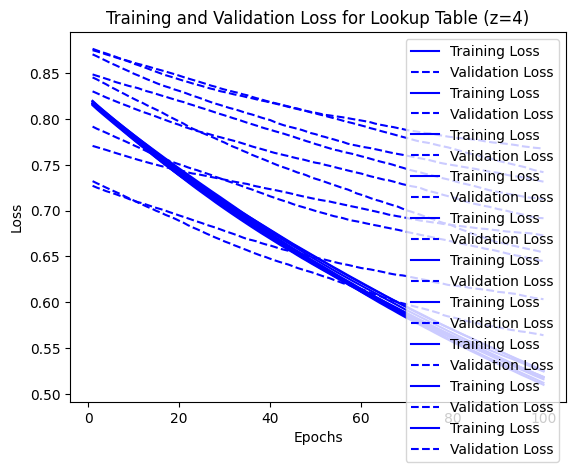

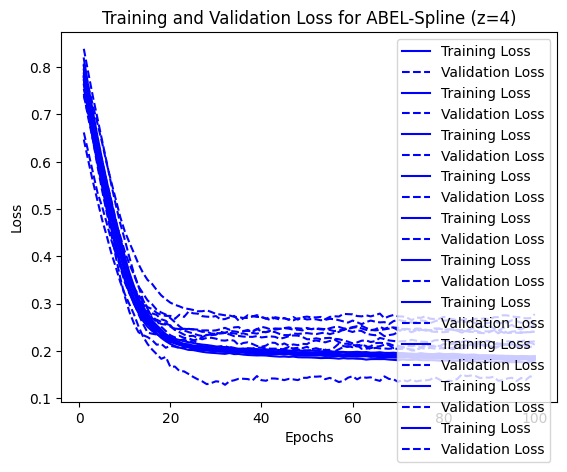

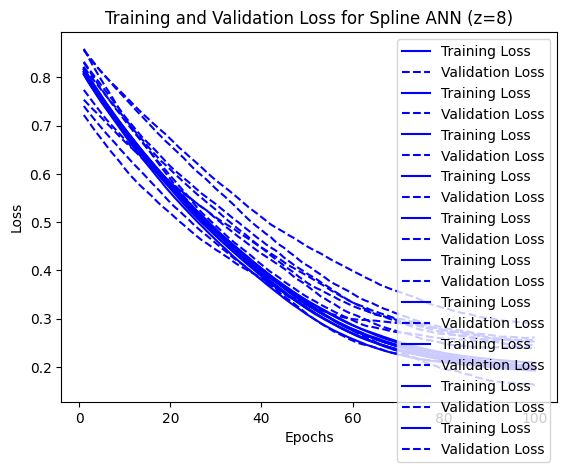

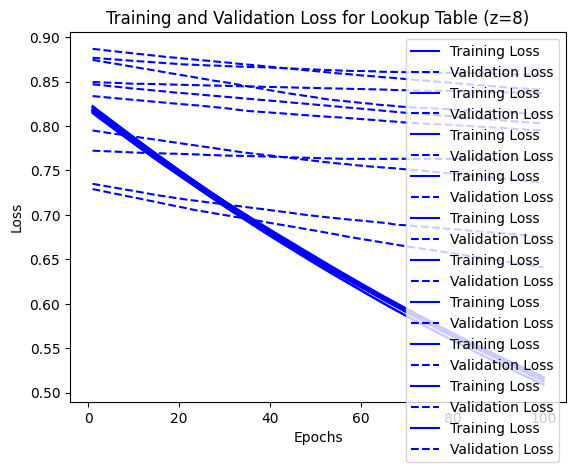

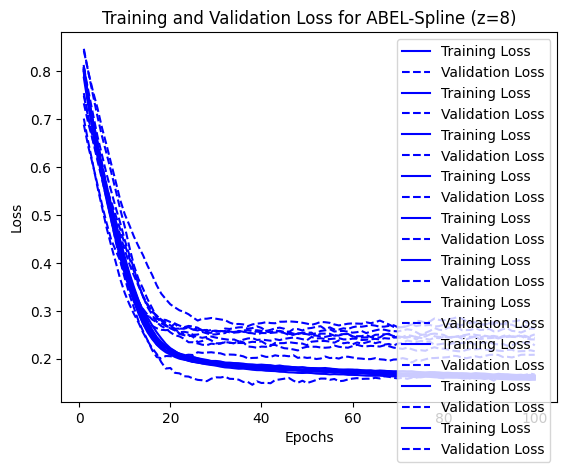

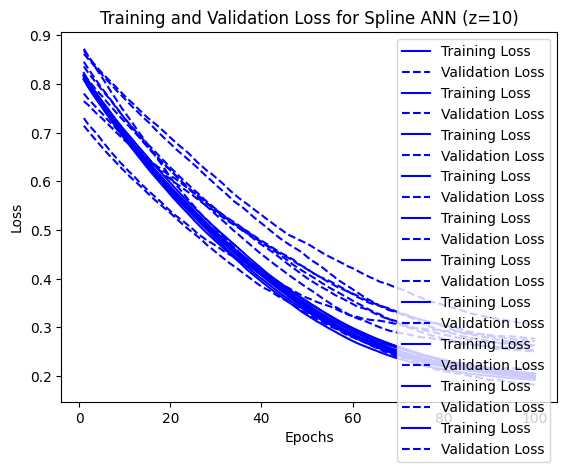

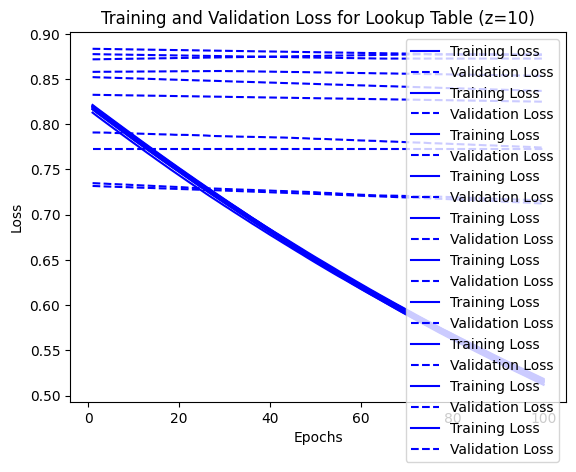

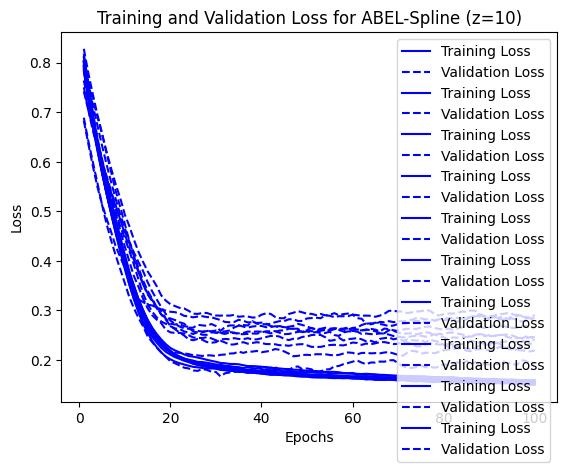

In [13]:
import matplotlib.pyplot as plt

def plot_curves(results):
    """
    Function to plot the training loss and validation curves for each model on separate axes.
    """
    
    # For each model
    for model_name, model_results in results.items():
        fig, ax = plt.subplots()

        # For each fold
        for result in model_results:
            train_loss = result['train_history']
            val_loss = result['val_history']

            epochs = range(1, len(train_loss) + 1)

            # Plotting training loss 
            ax.plot(epochs, train_loss, 'b', label='Training Loss')

            # Plotting validation loss 
            ax.plot(epochs, val_loss, 'b', linestyle='dashed', label='Validation Loss')

        ax.set_title(f'Training and Validation Loss for {model_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        
        plt.show()

# Use this function to plot the curves
plot_curves(results)

In [15]:
def get_results_for_dataset(dataset_name, epoch_number=100, num_folds=10):
    """
    Function to grab all the relevant information from the aggregate_results folder
    """

    model_names = create_model_name_list()
    
    results = {}

    for model_name in model_names:
        model_results = {}
        
        for fold in range(1, num_folds+1):
            file_path = f'aggregate_results/{dataset_name}-{model_name}-epochs-{epoch_number}-fold-{fold}-of-{num_folds}.npy'
            
            if os.path.exists(file_path):
                result = np.load(file_path, allow_pickle=True).item()
                model_results[fold] = result
        
        if model_results:
            results[model_name] = model_results
        
    return results

all_datasets_results = {}

for dataset in dataset_names:
    all_datasets_results[dataset] = get_results_for_dataset(dataset)

In [22]:
all_datasets_results['1027_ESL'][][9]['r_squared_value']

0.35904490720449556